<a href="https://colab.research.google.com/github/januverma/transformers-stuff/blob/main/GPT_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Transformer model has emerged as one of the most powerful neural network architecture in past couple of years. These models have enabled the development of large language models (LLMs) aka foundation models like GPT-3 and BERT. Ealrier this month, ChatGPT took the world by storm which is a GPT model trained to generate text in response to a human provided prompt. There is hardly any area of deep learning which is not revolutionized by the transformer models. It is worthwhile to understand various components of the transformer architecture. In this notebook, we will implement a transformer encoder model to build our own GPT model using PyTorch.

Let's start with importing relevant python libraries.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import math
import matplotlib.pyplot as plt

At a high-level, a transformer encoder layer consists of multi-head self-attention layer and a point-wise feed-forward block.  


## Multi-head self-attention block

Self-attention provides a mechanism for tokens at different positions in the sequence to interact with each other and computes scores which quantify the relative importance of the tokens for each other. The output of the attention module is a vector representation of each token which is defined as the weighted sum of the input token embeddings of all the tokens in the sequence. The weighting is provided by the attention scores. 

In general, attention can be defined for a given query and a set of key-value pairs where query, keys and values are all vectors. The output of the attention is vector which is the weighted sum of the value vectors where the weight for each value  depends on the compatibility of the corresponding key with the query. In the orginal paper, the authors adopted scaled dot-product attention which uses dot-products of the keys and the query  to compute attention weights.Let $K, Q, V$ be matrices of Keys, Queries and Values, then the attention score is computed as 
$$Attention(Q, K, V) = softmax(\frac{QK^T}{\sqrt{d}}) V$$ 

Following the original paper, we use multi-headed attention i.e. rather than only computing the attention once, the multi-head mechanism runs through the scaled dot-product attention multiple times in parallel. The output of each head is then concatenated and linearly transformed to produce single embedding for each token. Multi-headed attention has evolved to be a standard in attention models since it allows the model to jointly attend to information from different representation sub-spaces at different positions. 
$$MultiHead(Q, K, V) = Concat(Head_1, Head_2, \ldots Head_h)$$
$$Head_i = Attention(QW_i^Q, KW_i^K, VW_i^V)$$
where the projections are parameter matrices. 

In this tutorial, we will use PyTorch implementation of multi-head attention which comes as [`MultiheadAttention`](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html) layer. An advantage of using `MultiHeadAttention` layer is that it has support for adding masks which makes the architecture more flexible in terms on where to apply attention. There is a `key_mask` to choose tokens in the key to ignore (useful when e.g. padding is applied to sequences), and `attention_mask` which allows selection of positions to ignore (useful e.g. in autoregressive models where it is not okay to look forward or decoder models) while calculating the attention scores.

In [53]:
class MultiHeadSelfAttention(nn.Module):
    '''
    Implements MHSA using the PyTorch MultiheadAttention Layer.
    '''
    def __init__(self, hidden_dim, num_heads, dropout):
        '''
        Arguments:
            hidden_dim: Dimension of the output of the self-attention.
            num_heads: Number of heads for the multi-head attention. 
            dropout: Dropout probability for the self-attention. If `0.0` then no dropout will be used.
            
        Returns:
            A tensor of shape `num_tokens x hidden_size` containing output of the MHSA for each token.
        '''
        super().__init__()
        if hidden_dim % num_heads != 0:
            print('The hidden size {} is not a multiple of the number of heads {}'.format(hidden_dim, num_heads))
        self.attention_layer = nn.MultiheadAttention(hidden_dim, num_heads, dropout=dropout, batch_first=True)
    def forward(self, x, key_padding_mask=None, attention_mask=None):
        '''
        Arguments:
            x: Tensor containing input token embeddings.
            key_padding_mask: Mask indicating which elements within the input sequence to be considered as padding and ignored for the computation of self-attention scores.  
            attention_mask: Mask indicating which relative positions are allowed to attend.  
        '''
        return self.attention_layer(query=x, key=x, value=x, key_padding_mask=key_padding_mask, attn_mask=attention_mask)


Let's explore the working of the `MultiHeadAttention` layer a bit. Consider a random tensor called `key` which can be thought of as representing a sequence of length 5 where each element in the sequence is encoded with a 8-dimensional embedding. For example, key could be representing a sentence of 5 words where each word has 8-dimensional word embedding.  

In [54]:
num_batches = 1
seq_len = 5
embed_dim = 8
key = torch.randn(num_batches,seq_len,embed_dim)
key

tensor([[[ 1.3666,  0.3002,  3.2257, -2.1703, -1.0573,  2.2189,  1.4424,
          -0.7223],
         [-0.5133, -0.2807, -0.2915,  0.3097,  2.2854, -0.4527,  2.0117,
          -0.4278],
         [ 1.2703,  0.4770, -0.3417,  1.5140,  1.0205, -0.0381,  0.8618,
           1.5436],
         [-0.5828,  1.4535,  0.6763, -0.7810, -0.0103, -0.9812,  0.4252,
          -0.4465],
         [-1.5193, -0.2806,  0.4602, -1.5507, -0.7799, -0.5019,  0.8581,
           1.3342]]])

In [55]:
attention_hidden_size = embed_dim
num_heads = 1

In [56]:
mhsa = MultiHeadSelfAttention(attention_hidden_size, num_heads, dropout=0.1)
attention_output, attention_weights = mhsa(key)

The output of the self-attention operator produces a vector output embedding for each token in the sequence of dimension `attention_hidden_size` which are fed to the subsequent (attention or otherwise) layers. 

In [57]:
attention_output

tensor([[[ 0.4408, -0.4671,  0.0352, -0.3119,  0.0832, -0.3746, -0.2145,
          -0.2026],
         [ 0.6960, -0.4267,  0.1504, -0.3524,  0.1847, -0.2938, -0.3021,
          -0.4950],
         [ 0.7830, -0.3058,  0.1768, -0.2435,  0.2469, -0.1573, -0.3238,
          -0.6513],
         [ 0.4041, -0.1362,  0.1217, -0.2706,  0.1599, -0.2396, -0.1533,
          -0.3026],
         [ 0.5041, -0.2543,  0.1512, -0.3539,  0.2130, -0.2330, -0.2164,
          -0.4725]]], grad_fn=<TransposeBackward0>)

In addition, the `MultiHeadAttention` produces a tensor called `attention_weights` which contains the pair-wise attention-scores for the tokens i.e. their relative importance to each other. We get a `seq_length x seq_length` matrix.

In [58]:
attention_weights

tensor([[[0.0857, 0.2108, 0.5293, 0.1330, 0.1523],
         [0.2534, 0.2171, 0.3006, 0.1062, 0.2339],
         [0.3358, 0.0000, 0.1740, 0.1888, 0.2020],
         [0.1373, 0.0000, 0.2353, 0.2688, 0.2135],
         [0.1969, 0.2445, 0.0000, 0.1988, 0.1941]]], grad_fn=<DivBackward0>)

Plotting the attention weights on a grid gives high-level understanding of correlation between the tokens. In language translation tasks, such a heatmap provides a coarse word level translation or at least which words in the source sequence are most relevant for a word in the target sequence. 

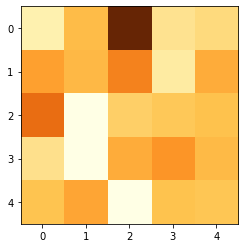

In [59]:
attention_weights = attention_weights.squeeze()
plt.imshow(attention_weights.detach(), cmap='YlOrBr')
plt.show()

## Feed-forward block

The output vector for each token in the sequence is fed to a neural network block consisting of feed-forward layers. 

In [60]:
class FeedForward(nn.Module):
    '''
    Implements the feed-forward component of the transfomer model.
    '''
    def __init__(self, input_dim, hidden_dim, dropout=0.0):
        '''
        Arguments:
            input_dim: Dimension of the token embedding, output of the MHSA layer.
            hidden_dim: Hidden size of the Transformer that this feed-forward layer is part of.
            dropout: Dropout probability to use for the projected activations. If `0.0` then no dropout will be used.
        Returns:
            A tensor of shape `num_tokens x hidden_dim` containing projections for each token.
        '''
        super().__init__()
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.layer_1 = nn.Linear(input_dim, hidden_dim)
        self.layer_2 = nn.Linear(hidden_dim, input_dim)
    def forward(self, x):
        x = self.layer_1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.layer_2(x)
        return x


In [61]:
ffn = FeedForward(embed_dim, hidden_dim=5)
key = ffn(attention_output)
key

tensor([[[ 0.1737, -0.2318,  0.2350,  0.1964,  0.2446, -0.0070,  0.0463,
          -0.2898],
         [ 0.1651, -0.2303,  0.2282,  0.2182,  0.2526, -0.0022,  0.0394,
          -0.2952],
         [ 0.1665, -0.2345,  0.2275,  0.2146,  0.2520, -0.0010,  0.0427,
          -0.2961],
         [ 0.1863, -0.2666,  0.2316,  0.1678,  0.2380,  0.0014,  0.0725,
          -0.2945],
         [ 0.1715, -0.2526,  0.2236,  0.2008,  0.2501,  0.0049,  0.0569,
          -0.3008]]], grad_fn=<ViewBackward0>)

## Naive Transformer Layer

We are now ready to put together our first version of a transformer encoder layer as a sequential model comprising of multi-head self attention layer and a point-wise feed-forward layer.

In [62]:
class TransformerLayer(nn.Module):
    '''
    Implements a transformer layer as a stack of MHSA and feed-forward blocks.

    Arguments:
      hidden_dim: Hidden dimension of the transformer layers.
      num_heads: Number of attention heads.  
      attn_dropout: Dropout for MHSA layers. 
        ffn_dropout: Dropout for feed-forward layers.

    Returns:
        A tensor containing attention scores for each token. 
        attn_weights: A tensor of shape `num_tokens x num_tokens` containing the attention weights.
    '''
    def __init__(self, hidden_dim, num_heads, attn_dropout=0.0, ffn_dropout=0.0):
        super().__init__()
        self.attn_layer = MultiHeadSelfAttention(hidden_dim, num_heads, dropout=attn_dropout)
        self.ffn_layer = FeedForward(hidden_dim, hidden_dim, dropout=ffn_dropout)
    def forward(self, x, key_padding_mask=None, attention_mask=None):
        attn_out, attn_weights = self.attn_layer(x, key_padding_mask, attention_mask)
        out = self.ffn_layer(attn_out)
        return out, attn_weights

In [63]:
transfomer_layer = TransformerLayer(hidden_dim=embed_dim, num_heads=1)
out, weights = transfomer_layer(key)
out

tensor([[[ 0.0452,  0.2929,  0.0269,  0.0169,  0.3146,  0.3038, -0.0533,
           0.1584],
         [ 0.0452,  0.2929,  0.0269,  0.0169,  0.3146,  0.3038, -0.0533,
           0.1584],
         [ 0.0452,  0.2929,  0.0269,  0.0169,  0.3146,  0.3038, -0.0533,
           0.1584],
         [ 0.0452,  0.2929,  0.0269,  0.0169,  0.3146,  0.3038, -0.0533,
           0.1584],
         [ 0.0452,  0.2929,  0.0269,  0.0169,  0.3146,  0.3038, -0.0533,
           0.1584]]], grad_fn=<ViewBackward0>)

In [64]:
weights

tensor([[[0.2002, 0.1998, 0.1998, 0.2004, 0.1998],
         [0.2002, 0.1998, 0.1998, 0.2004, 0.1998],
         [0.2002, 0.1998, 0.1998, 0.2004, 0.1998],
         [0.2002, 0.1998, 0.1998, 0.2004, 0.1998],
         [0.2002, 0.1998, 0.1998, 0.2004, 0.1998]]], grad_fn=<DivBackward0>)

## Strategies for stable transformer models

In the original paper, Attention is all you need, the authors adopted some techniques to achieve stability in the training process and allow for these models to learn complex relations. 

- ### Residual Connections
 Both the self-attention and feed-forward layers are equipped with residual connections around them. Residual connections work by adding the input of a layer to the output of the layer, thus providing an alternate path for the information to flow through the network. Residual connections were first used in ResNets to train very deep convolutional networks, and have since become standard in deep neural networks to provide a stable training. 
 
 Mathematically, residual connections can simply be described as addition. 
$$X → X + MHSA(X)$$
$$X → FFN(X)$$


In [65]:
class TransformerLayer(nn.Module):
    '''
    '''
    def __init__(self, embed_dim, num_heads, hidden_dim, attn_dropout=0.0, ffn_dropout=0.0):
        super().__init__()
        self.attn_layer = MultiHeadSelfAttention(embed_dim, num_heads, dropout=attn_dropout)
        self.ffn_layer = FeedForward(embed_dim, hidden_dim, dropout=ffn_dropout)
    def forward(self, x, key_padding_mask=None, attention_mask=None):
        attn_out, attn_weights = self.attn_layer(x, key_padding_mask, attention_mask)
        x = x + attn_out
        ffn_out = self.ffn_layer(x)
        out = x + ffn_out
        return out, attn_weights

In [66]:
transfomer_layer = TransformerLayer(embed_dim=embed_dim, num_heads=1, hidden_dim=embed_dim)
out, weights = transfomer_layer(key)
out

tensor([[[ 0.2494, -0.6382,  0.1762, -0.0437,  0.4116, -0.2612,  0.1003,
          -0.1834],
         [ 0.2402, -0.6386,  0.1717, -0.0222,  0.4177, -0.2570,  0.0897,
          -0.1875],
         [ 0.2415, -0.6429,  0.1715, -0.0260,  0.4168, -0.2558,  0.0923,
          -0.1883],
         [ 0.2620, -0.6742,  0.1768, -0.0739,  0.4030, -0.2531,  0.1223,
          -0.1875],
         [ 0.2463, -0.6622,  0.1701, -0.0407,  0.4137, -0.2503,  0.1030,
          -0.1922]]], grad_fn=<AddBackward0>)

In [67]:
weights

tensor([[[0.2002, 0.2002, 0.2002, 0.1996, 0.1998],
         [0.2002, 0.2002, 0.2002, 0.1996, 0.1998],
         [0.2002, 0.2002, 0.2002, 0.1996, 0.1998],
         [0.2002, 0.2002, 0.2002, 0.1996, 0.1998],
         [0.2002, 0.2002, 0.2002, 0.1996, 0.1998]]], grad_fn=<DivBackward0>)

- ### Layer Normalization
After each residual connection, a [Layer Normalization](https://arxiv.org/abs/1607.06450) has been applied to the output. This stablizes the training by decreasing the chances that the values start to go to extremes. Layer normalization achieves this by centering all the values relative to the mean. 
Mathematically, 

$$y = \frac{x - \mathrm{E}[x]}{ \sqrt{\mathrm{Var}[x] + \epsilon}} * \gamma + \beta$$

where $\gamma$ and $\beta$ are learnable affine parameters. 

In [68]:
class TransformerLayerNorm(nn.Module):
    '''
    Implements LayerNorm for self-attention and feed-forward networks.

    Arguments:
        input_dim: Input dimension.
    
    Returns:
        A normalized tensor of the same dimension as the input. 
    '''
    def __init__(self, input_dim):
        super().__init__()
        self.layer_norm = nn.LayerNorm(input_dim)
    def forward(self, x):
        x = x.to(self.layer_norm.weight.dtype)
        return self.layer_norm(x) 

In [69]:
layer_norm = TransformerLayerNorm(embed_dim)
key = layer_norm(key)
key

tensor([[[ 0.6523, -1.4180,  0.9652,  0.7684,  1.0143, -0.2703,  0.0021,
          -1.7140],
         [ 0.5956, -1.3976,  0.9134,  0.8630,  1.0364, -0.2480, -0.0383,
          -1.7245],
         [ 0.6035, -1.4128,  0.9104,  0.8457,  1.0336, -0.2388, -0.0189,
          -1.7227],
         [ 0.7186, -1.5383,  0.9447,  0.6266,  0.9765, -0.2028,  0.1517,
          -1.6771],
         [ 0.6316, -1.4749,  0.8906,  0.7772,  1.0225, -0.1955,  0.0628,
          -1.7143]]], grad_fn=<NativeLayerNormBackward0>)

This allows us to put together a transformer layer as a sequential model
$$X → X + MHSA(X)$$
$$X → LayerNorm(X)$$
$$X → FFN(X)$$
$$X → LayerNorm(X)$$

In [70]:
class TransformerLayer(nn.Module):
    '''
    A transformer layer which is a sequential model consisting of self-attention, layer norm, residual connection, feed-forward projection, layer norm, residual connection. 
    
    Arguments:
        hidden_dim: Hidden dimension transformer layers.  
        num_heads: Number of attention heads. 
        attn_dropout: Dropout for MHSA layers. 
        ffn_dropout: Dropout for feed-forward layers.
    Returns:
        A tensor containing attention scores for each token. 
        attn_weights: A tensor of shape `num_tokens x num_tokens` containing the attention weights. 
    '''
    def __init__(self, hidden_dim, num_heads, attn_dropout=0.0, ffn_dropout=0.0):
        super().__init__()
        self.attn_layer = MultiHeadSelfAttention(hidden_dim, num_heads, dropout=attn_dropout)
        self.ffn_layer = FeedForward(hidden_dim, hidden_dim, dropout=ffn_dropout)
        self.layer_norm = TransformerLayerNorm(hidden_dim)
    def forward(self, x, key_padding_mask=None, attention_mask=None):
        attn_out, attn_weights = self.attn_layer(x, key_padding_mask, attention_mask)
        x = self.layer_norm(x + attn_out)
        ffn_out = self.ffn_layer(x)
        x = self.layer_norm(x + ffn_out)
        return x, attn_weights

In [71]:
transfomer_layer = TransformerLayer(hidden_dim=embed_dim, num_heads=1)
out, weights = transfomer_layer(key)
out

tensor([[[-0.0717, -1.3824,  1.0876,  0.1094,  1.7286,  0.1873, -0.3345,
          -1.3244],
         [-0.1299, -1.3645,  1.0411,  0.1988,  1.7466,  0.2046, -0.3658,
          -1.3309],
         [-0.1194, -1.3775,  1.0383,  0.1796,  1.7440,  0.2159, -0.3521,
          -1.3288],
         [ 0.0144, -1.4843,  1.0664, -0.0423,  1.6944,  0.2670, -0.2255,
          -1.2901],
         [-0.0799, -1.4297,  1.0192,  0.1028,  1.7331,  0.2673, -0.2943,
          -1.3185]]], grad_fn=<NativeLayerNormBackward0>)

In [72]:
weights

tensor([[[0.1999, 0.2029, 0.2022, 0.1953, 0.1996],
         [0.1998, 0.2033, 0.2025, 0.1947, 0.1997],
         [0.1998, 0.2033, 0.2025, 0.1947, 0.1997],
         [0.2000, 0.2026, 0.2020, 0.1958, 0.1996],
         [0.1999, 0.2032, 0.2024, 0.1948, 0.1997]]], grad_fn=<DivBackward0>)

#### Transformer Encoder
Finally, a transformer encoder is a stacked block of transformer layers each with their own layer normalization and residual connection. 

In [75]:
class TransformerEncoder(nn.Module):
    '''
    Transformer Encoder which is composed for a stack of TransformerLayers. 

    Arguments:
        num_layers: Number of Transformer layers in the encoder. 
        hidden_dim: Hidden dimension of the transformer layers.  
        num_heads: Number of heads. 
        attn_dropout: Dropout for MHSA layers. 
        ffn_dropout: Dropout for feed-forward layers.
    '''
    def __init__(self, num_layers, hidden_dim, num_heads, attn_dropout=0.0, ffn_dropout=0.0):
        super().__init__()
        self.layers = nn.ModuleList([TransformerLayer(hidden_dim, num_heads, attn_dropout, ffn_dropout) for _ in range(num_layers)])
        self.attn_weights = []
    def forward(self, x, key_padding_mask=None, attention_mask=None):
        for layer in self.layers:
            x, weights = layer(x, key_padding_mask, attention_mask)
            self.attn_weights.append(weights)
        return x
    def get_attention_weights(self):
        if len(self.attn_weights) != 0:
            return self.attn_weights
        else:
            print("The model hasn't been training yet")

In [76]:
encoder = TransformerEncoder(num_layers=5, num_heads=2, hidden_dim=embed_dim)
attn_out = encoder(key)
attn_out

tensor([[[ 0.4970, -0.6345,  0.4218,  1.0914,  1.2542, -1.1688,  0.2631,
          -1.7242],
         [ 0.4404, -0.5929,  0.3503,  1.1595,  1.2712, -1.1390,  0.2465,
          -1.7359],
         [ 0.4536, -0.6145,  0.3589,  1.1506,  1.2662, -1.1340,  0.2542,
          -1.7349],
         [ 0.5825, -0.7815,  0.4754,  1.0250,  1.2125, -1.1399,  0.3278,
          -1.7019],
         [ 0.4975, -0.6914,  0.3781,  1.1236,  1.2443, -1.1137,  0.2922,
          -1.7306]]], grad_fn=<NativeLayerNormBackward0>)

In [77]:
encoder.get_attention_weights()

[tensor([[[0.1999, 0.1993, 0.1995, 0.2012, 0.2001],
          [0.1997, 0.1995, 0.1996, 0.2009, 0.2003],
          [0.1997, 0.1995, 0.1996, 0.2009, 0.2003],
          [0.2001, 0.1992, 0.1994, 0.2013, 0.1999],
          [0.1998, 0.1994, 0.1996, 0.2009, 0.2002]]], grad_fn=<DivBackward0>),
 tensor([[[0.2004, 0.2054, 0.2040, 0.1909, 0.1994],
          [0.2004, 0.2055, 0.2040, 0.1907, 0.1993],
          [0.2004, 0.2054, 0.2040, 0.1909, 0.1993],
          [0.2004, 0.2045, 0.2033, 0.1923, 0.1995],
          [0.2004, 0.2049, 0.2036, 0.1917, 0.1994]]], grad_fn=<DivBackward0>),
 tensor([[[0.2000, 0.2021, 0.2014, 0.1971, 0.1995],
          [0.1999, 0.2023, 0.2015, 0.1967, 0.1996],
          [0.1999, 0.2023, 0.2015, 0.1967, 0.1996],
          [0.2002, 0.2021, 0.2013, 0.1971, 0.1993],
          [0.2000, 0.2023, 0.2015, 0.1967, 0.1995]]], grad_fn=<DivBackward0>),
 tensor([[[0.1978, 0.2036, 0.2027, 0.1947, 0.2012],
          [0.1978, 0.2035, 0.2026, 0.1950, 0.2012],
          [0.1978, 0.2035, 0.2026, 

In [78]:
encoder

TransformerEncoder(
  (layers): ModuleList(
    (0): TransformerLayer(
      (attn_layer): MultiHeadSelfAttention(
        (attention_layer): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=8, out_features=8, bias=True)
        )
      )
      (ffn_layer): FeedForward(
        (activation): ReLU()
        (dropout): Dropout(p=0.0, inplace=False)
        (layer_1): Linear(in_features=8, out_features=8, bias=True)
        (layer_2): Linear(in_features=8, out_features=8, bias=True)
      )
      (layer_norm): TransformerLayerNorm(
        (layer_norm): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
      )
    )
    (1): TransformerLayer(
      (attn_layer): MultiHeadSelfAttention(
        (attention_layer): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=8, out_features=8, bias=True)
        )
      )
      (ffn_layer): FeedForward(
        (activation): ReLU()
        (dropout): Dropout(p=0.0, inplace=False

#### Positional Encoding
The transformer model that we have constructed is oblivious to the positions of the tokens in the sequence. The architecture is permutation-equivariant. In sequence modeling tasks, for example language understanding, position of tokens is important to interpret the input sequence. Past sequence modeling approaches like RNNs and CNNs have been crafted keeping the position in consideration. To be able to apply the transformer models to the sequence modeling tasks, it is important to have a mechanism to provide the positional information. In the original paper, Vaswani et al. proposed adding positional encoding to the input token embeddings before feeding them to the transformer model. The specific positional encoding employed are vectors of dimension same as the token embedding and are built using sine and cosine functions as

$$PE_{(pos, 2i)} = sin(pos/10000^{2i/d})$$
$$PE_{(pos, 2i+1)} = cos(pos/10000^{2i/d})$$

where $pos$ is the position and $i$ is the hidden encoding dimension. Thus each dimension of the positional encoding corresponds to a sinusoidal. A motivation for this choice of encoding is that $PE_{(pos + k,)}$ can be represented as a linear function of $PE_{(pos,)}$ which might allow the model to easily attend to relative positions. 


Let's implement this positional encoding.

In [79]:
class PositionalEncoding(nn.Module):
    '''
    Implements the sinusoidal positional encoding for the input tokens. 

    Arguments:
        embed_dim: Dimension of the positional encoding, should be the same as input token embedding. 
        dropout: Dropout probability to be used for positional encoding. 
        max_len: Maximum length of the input token sequences. 
    Returns:
      A tensor containing positional embeddings for each token.
    '''
    def __init__(self, embed_dim, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2) * (-math.log(10000.0)/embed_dim))
        self.pe = torch.zeros(max_len, 1, embed_dim)
        self.pe[:, 0, 0::2] = torch.sin(position * div_term)
        self.pe[:, 0, 1::2] = torch.cos(position * div_term)
    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [80]:
pos_enc = PositionalEncoding(embed_dim)
pos_enc(key)

tensor([[[ 0.7247, -0.4644,  1.0725,  1.9649,  1.1270,  0.8108,  0.0023,
          -0.0000],
         [ 0.6618, -0.4417,  1.0149,  2.0700,  1.1516,  0.8356, -0.0000,
          -0.8050],
         [ 0.6706, -0.4587,  1.0116,  2.0508,  1.1484,  0.8458, -0.0210,
          -0.8031],
         [ 0.7984, -0.5981,  0.0000,  1.8073,  1.0850,  0.8858,  0.0000,
          -0.7523],
         [ 0.7018, -0.5277,  0.9896,  1.9747,  0.0000,  0.8939,  0.0697,
          -0.7937]]], grad_fn=<MulBackward0>)

To see how positional embeddings work, we can visualize the values that get added to each embedding in each dimension of the embedding. Here we generate a heatmap of the values of positional encoding over positions, each row corresponds to the positional encoding in a fixed hidden dimension over all the positions.

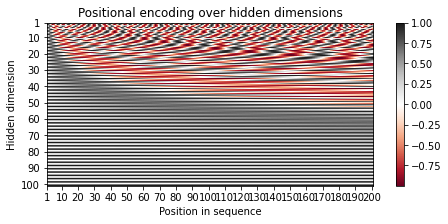

In [81]:
pos_enc = PositionalEncoding(100, max_len=200)
pe = pos_enc.pe.squeeze().T.numpy()


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 3))
pos = ax.imshow(pe, cmap="RdGy", extent=(1, pe.shape[1] + 1, pe.shape[0] + 1, 1))
fig.colorbar(pos, ax=ax)
ax.set_xlabel("Position in sequence")
ax.set_ylabel("Hidden dimension")
ax.set_title("Positional encoding over hidden dimensions")
ax.set_xticks([1] + [i * 10 for i in range(1, 1 + pe.shape[1] // 10)])
ax.set_yticks([1] + [i * 10 for i in range(1, 1 + pe.shape[0] // 10)])
plt.show()

We can clearly see sine and cosine waves with different wavelenths that encode the positions in the hidden dimensions. 

Further, we visualize the positional encoding for the hidden dimension 1,2,3 and 4. 

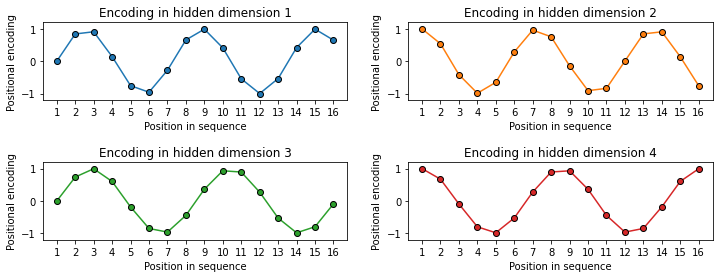

In [82]:
fig, ax = plt.subplots(2, 2, figsize=(12, 4))
ax = [a for a_list in ax for a in a_list]
for i in range(len(ax)):
    ax[i].plot(np.arange(1, 17), pe[i, :16], color="C%i" % i, marker="o", markersize=6, markeredgecolor="black")
    ax[i].set_title("Encoding in hidden dimension %i" % (i + 1))
    ax[i].set_xlabel("Position in sequence", fontsize=10)
    ax[i].set_ylabel("Positional encoding", fontsize=10)
    ax[i].set_xticks(np.arange(1, 17))
    ax[i].tick_params(axis="both", which="major", labelsize=10)
    ax[i].tick_params(axis="both", which="minor", labelsize=8)
    ax[i].set_ylim(-1.2, 1.2)
fig.subplots_adjust(hspace=0.8)

In [83]:
class MyGPT(nn.Module):
    '''
    GPT-like language model.

    Arguments:
        vocab_size: Size of vocabulary.
        embed_dim: Dimension of the input token embedding. 
        num_layers: Number of Transformer layers in the encoder. 
        hidden_dim: Hidden dimension of the transformer layers.  
        ffn_hidden_dim: Hidden dimension of the Feed-forward layers. 
        num_heads: Number of heads. 
        attn_dropout: Dropout for MHSA layers. 
        ffn_dropout: Dropout for feed-forward layers.
    '''
    def __init__(self, vocab_size, embed_dim, num_layers, num_heads, attn_dropout, ffn_dropout):
        super(MyGPT, self).__init__()
        self.embedding_layer = nn.Embedding(vocab_size, embed_dim)
        self.pos_encoder = PositionalEncoding(embed_dim)
        self.transformer_encoder = TransformerEncoder(num_layers, embed_dim, num_heads, attn_dropout, ffn_dropout)
        self.decoder = nn.Linear(embed_dim, vocab_size)
        self.embed_layer_norm = nn.LayerNorm(embed_dim)
        self.init_weights()

    def init_weights(self):
        init_range = 0.5
        self.decoder.weight.data.uniform_(-init_range, init_range)
        self.decoder.bias.data.zero_()
        
    
    def forward(self, seqs, attn_mask=None, key_padding_mask=None):
        embedded_seq = self.embedding_layer(seqs)
        embedded_seq = self.pos_encoder(embedded_seq)
        embedded_seq = self.embed_layer_norm(embedded_seq)
        out = self.transformer_encoder(x=embedded_seq, key_padding_mask=key_padding_mask, attention_mask=attn_mask)
        results = self.decoder(out)
        return results
      
    def get_attn_weights(self):
      return self.transformer_encoder.get_attention_weights()

In [84]:
vocabulary_size = 10
seq_length = 8
num_seqs = 5
x = torch.randint(vocabulary_size, (num_seqs, seq_length))
x.shape

torch.Size([5, 8])

In [85]:
x

tensor([[2, 8, 0, 0, 9, 9, 9, 2],
        [8, 0, 1, 8, 2, 9, 6, 3],
        [7, 7, 0, 5, 1, 7, 2, 7],
        [2, 3, 0, 6, 5, 3, 0, 3],
        [3, 4, 0, 9, 8, 6, 2, 6]])

In [86]:
model = MyGPT(vocab_size=vocabulary_size, embed_dim=64, num_layers=2, num_heads=2, attn_dropout=0.3, ffn_dropout=0.1)

In [87]:
y = model(x)

In [88]:
y

tensor([[[ 0.5538, -0.9655, -0.2114,  0.3255,  3.7826, -2.0932,  2.4401,
           1.9437,  1.6627, -1.1368],
         [-0.4130,  1.4705,  0.4886,  2.3956,  1.0408,  4.6443, -0.0127,
          -2.8765,  1.8967, -4.8898],
         [-2.8881,  3.3545, -0.1635,  1.0542, -0.2818,  3.4571, -3.4251,
           0.3699, -0.5231,  0.3577],
         [-0.3912,  4.5304, -1.0740,  1.1999,  0.3905,  3.5423, -3.7838,
          -0.3086,  0.6252,  1.1353],
         [-2.4198,  2.9980,  1.7149, -1.6793,  1.8955,  4.2764, -4.9772,
           1.2452, -4.0753, -1.3832],
         [-1.6980,  0.4211,  1.1076, -0.7423,  2.7173,  4.0816, -4.2425,
           3.4285, -3.9942, -0.8829],
         [-3.7988,  1.1590,  1.2091, -1.2984,  1.7106,  3.4663, -3.6836,
           2.7338, -4.1580,  0.1947],
         [-0.4154, -1.3298, -0.0483,  0.3889,  4.0009, -0.8270,  2.8111,
           2.1943,  2.2104, -0.6873]],

        [[ 2.2071,  2.0732,  1.6402,  3.3526,  0.6989,  6.5105, -1.9483,
          -4.4777, -0.4824, -4.3081],

In [89]:
y.shape

torch.Size([5, 8, 10])

In [90]:
attn_weights = model.get_attn_weights()
len(attn_weights)

2

In [91]:
attn_weights[1]

tensor([[[0.1372, 0.1781, 0.2368, 0.2057, 0.0000, 0.1790, 0.0697, 0.1454],
         [0.2269, 0.0656, 0.1025, 0.0310, 0.1245, 0.1589, 0.0683, 0.2653],
         [0.0000, 0.0852, 0.2156, 0.2704, 0.1579, 0.0879, 0.1205, 0.1530],
         [0.0000, 0.0797, 0.3178, 0.2861, 0.1612, 0.1047, 0.1262, 0.1423],
         [0.1785, 0.1505, 0.2558, 0.0000, 0.0000, 0.0569, 0.1406, 0.1966],
         [0.2842, 0.0000, 0.1101, 0.1658, 0.0000, 0.0000, 0.0702, 0.2990],
         [0.0960, 0.0000, 0.2226, 0.0000, 0.0340, 0.1563, 0.0558, 0.2279],
         [0.0000, 0.0829, 0.0000, 0.0946, 0.1715, 0.0801, 0.1793, 0.0706]],

        [[0.1075, 0.0394, 0.0467, 0.1653, 0.0646, 0.0805, 0.0618, 0.1547],
         [0.1561, 0.4013, 0.0924, 0.0533, 0.0000, 0.0478, 0.0841, 0.1081],
         [0.0681, 0.1508, 0.0716, 0.0524, 0.1282, 0.2920, 0.1886, 0.1863],
         [0.2029, 0.1787, 0.2049, 0.1599, 0.1856, 0.0875, 0.1841, 0.0000],
         [0.1666, 0.0997, 0.1611, 0.1481, 0.0000, 0.1931, 0.2731, 0.1449],
         [0.1227, 0.199

In [92]:
model

MyGPT(
  (embedding_layer): Embedding(10, 64)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerLayer(
        (attn_layer): MultiHeadSelfAttention(
          (attention_layer): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
          )
        )
        (ffn_layer): FeedForward(
          (activation): ReLU()
          (dropout): Dropout(p=0.1, inplace=False)
          (layer_1): Linear(in_features=64, out_features=64, bias=True)
          (layer_2): Linear(in_features=64, out_features=64, bias=True)
        )
        (layer_norm): TransformerLayerNorm(
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
      )
      (1): TransformerLayer(
        (attn_layer): MultiHeadSelfAttention(
          (attention_layer): MultiheadAttention(
            (out_p

#### Auto-regressive Language Model

For a autoregressive language model, the self-attention layers are only allowed to attend to earlier positions in the sequence, looking into the future is not allowed. We will require an attention mask which prevents peeking into future using upper-triangular matrix of ones. 


In [93]:
def generate_square_subsequent_mask(sz):
    """
    Generates an upper-triangular matrix of ones, with zeros on diag.
    Shape max_length * max_length
    """
    return torch.triu(torch.ones(sz, sz, dtype=torch.bool), diagonal=1)

In [94]:
generate_square_subsequent_mask(5)

tensor([[False,  True,  True,  True,  True],
        [False, False,  True,  True,  True],
        [False, False, False,  True,  True],
        [False, False, False, False,  True],
        [False, False, False, False, False]])

To follow the requirements of the PyTorch `MultiHeadAttention` layer, the `True` value at `(i,j)`-th place indicates that the self-attention for `i`-th position can not look at `j`-th position. 

Back to our GPT model, we would require an attention mask `attn_mask` 

In [95]:
attn_mask = generate_square_subsequent_mask(seq_length)
attn_mask

tensor([[False,  True,  True,  True,  True,  True,  True,  True],
        [False, False,  True,  True,  True,  True,  True,  True],
        [False, False, False,  True,  True,  True,  True,  True],
        [False, False, False, False,  True,  True,  True,  True],
        [False, False, False, False, False,  True,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False, False,  True],
        [False, False, False, False, False, False, False, False]])

In [96]:
y = model(x, attn_mask=attn_mask)

In [97]:
y

tensor([[[ 1.7974e+00,  7.2112e-01, -7.8530e-02,  4.8879e-01,  3.5751e+00,
          -2.4817e+00,  2.0186e+00,  1.4142e+00,  1.8569e+00, -1.3372e+00],
         [ 3.0068e-01,  2.5702e+00,  6.7665e-01,  1.9813e+00,  1.6985e+00,
           4.0547e+00, -4.8453e-01, -2.6835e+00,  1.9968e+00, -4.3766e+00],
         [ 1.1401e+00,  5.4791e+00, -2.5561e+00, -1.1816e+00,  1.5839e+00,
           1.5675e+00, -2.4823e+00, -6.4347e-02,  1.4122e+00,  1.0774e+00],
         [-2.7872e-01,  4.5330e+00, -2.1399e+00,  1.6308e+00, -2.3378e+00,
           2.9814e+00, -3.9714e+00,  1.6348e+00,  7.9497e-02,  1.0263e+00],
         [-2.6267e+00,  3.2035e+00,  1.6754e+00, -1.9250e+00,  6.3431e-01,
           3.4647e+00, -5.2544e+00,  2.2085e+00, -3.9343e+00, -9.9813e-01],
         [-1.5112e+00,  2.5731e-01,  2.6547e+00, -3.5589e-01,  3.0056e-01,
           5.2017e+00, -3.1953e+00,  2.0065e+00, -3.8659e+00, -1.0345e+00],
         [-1.6251e+00,  2.6326e+00,  2.4651e+00, -1.4558e+00,  5.9543e-01,
           3.0159e+

This network produces a 10-dimensional output for each token, where 10 is the size of the vocabulary. It can be viewed as capturing the probabilities of the next token over the whole vocabulary. Such a network can be trained using well-crafted training data of sequences e.g, 
$$X = [A, B, C]$$
$$Y = [B, C, D]$$

Let's look at the attention weights. 

In [99]:
attn_weights = model.get_attn_weights()
len(attn_weights)

4

In [100]:
attn_weights[3]

tensor([[[1.4286, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.7654, 0.3419, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.4977, 0.2518, 0.5794, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.1874, 0.4689, 0.2164, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.1868, 0.0512, 0.2236, 0.1321, 0.2359, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.1915, 0.1258, 0.1056, 0.2487, 0.0000, 0.0000],
         [0.2112, 0.0305, 0.3023, 0.1016, 0.1891, 0.2077, 0.1193, 0.0000],
         [0.1667, 0.1038, 0.2294, 0.0949, 0.1713, 0.0000, 0.0835, 0.0000]],

        [[1.4286, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.2348, 0.6909, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.4058, 0.2164, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.1172, 0.0590, 0.1789, 0.1317, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.1490, 0.1841, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.2091, 0.151

Worth noting that the attention weight matrices are lower triangular which highlights the fact that the attention mask prohibits peeking into the future. 

This has been the first notebook in my series on transformer models. Next, we will implement data processing and training pipelines. 